# 测试

In [1]:
from tvm import relay
from tvm.ir import IRModule

data = relay.var("data")
bias = relay.var("bias")
add_op = data + bias

mod = IRModule()

mod['AddFunc'] = relay.Function([data, bias], add_op)

a, b, c = [relay.var(name) for name in "abc"]
add_gvar = mod.get_global_var('AddFunc')
add_01 = relay.Call(add_gvar, [a, b])
add_012 = relay.Call(add_gvar, [c, add_01])

mod['main'] = relay.Function([a, b, c], add_012)
print(mod)

def @AddFunc(%data, %bias) {
  add(%data, %bias)
}

def @main(%a, %b, %c) {
  %0 = @AddFunc(%a, %b);
  @AddFunc(%c, %0)
}



In [2]:
mod.functions

{GlobalVar(AddFunc): fn (%data, %bias) {
  add(%data, %bias)
}, GlobalVar(main): fn (%a, %b, %c) {
  %0 = @AddFunc(%a, %b);
  @AddFunc(%c, %0)
}}

In [4]:
from tvm.relay.dataflow_pattern import *
from tvm import relay
from tvm.ir import IRModule
from tvm_book.testing.relay.viz import graphviz_relay

In [5]:
def test_match_op_or():
    is_add_or_sub = is_op('add') | is_op('subtract')
    assert is_add_or_sub.match(relay.op.op.get("add"))
    assert is_add_or_sub.match(relay.op.op.get("subtract"))

In [6]:
test_match_op_or()
K_ELEMWISE = 0
K_BROADCAST = 1

In [7]:
def test_no_match_attr():
    op = is_op('nn.dense').has_attr({"TOpPattern": K_ELEMWISE})
    op_pat = op(wildcard(), wildcard())
    x = relay.var('x')
    y = relay.var('y')
    assert not op_pat.match(relay.op.nn.dense(x, y))

In [8]:
x = relay.var("x")
y = relay.var("y")
add_pattern = is_op("add")(wildcard(), wildcard())
sub_pattern = is_op("subtract")(wildcard(), wildcard())


class TestRewrite(DFPatternCallback):
    def __init__(self,
                 require_type=False,
                 rewrite_once=True):
        super().__init__(require_type=require_type,
                         rewrite_once=rewrite_once)
        self.pattern = add_pattern

    def callback(self, pre, post, node_map):
        return post.args[0] - post.args[1]

out = rewrite(TestRewrite(), x + y)
assert sub_pattern.match(out)

In [9]:
# A pattern matching conv2d+relu.
pattern = is_op("nn.relu")(is_op("nn.conv2d")(wildcard(), wildcard()))

# A graph.
x = relay.var('input')
w = relay.var('weight')
conv2d = relay.nn.conv2d(x, w)
relu = relay.nn.relu(conv2d)
main_func = relay.Function([x, w], relu)
mod = IRModule()
mod["main"] = main_func
print(mod)

def @main(%input, %weight) {
  %0 = nn.conv2d(%input, %weight, padding=[0, 0, 0, 0]);
  nn.relu(%0)
}



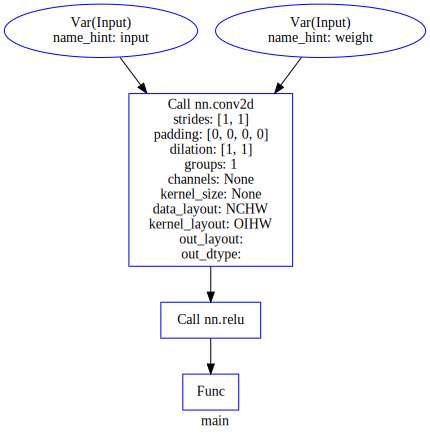

In [10]:
graphviz_relay(mod, "main")

In [11]:
# After partition.
new = pattern.partition(relu)
func = relay.Function([x, w], new)
mod["new"] = func

In [12]:
print(func)

fn (%input, %weight) {
  %1 = fn (%FunctionVar_0_0, %FunctionVar_0_1, PartitionedFromPattern="nn.conv2d_nn.relu_") {
    %0 = nn.conv2d(%FunctionVar_0_0, %FunctionVar_0_1, padding=[0, 0, 0, 0]);
    nn.relu(%0)
  };
  %1(%input, %weight)
}


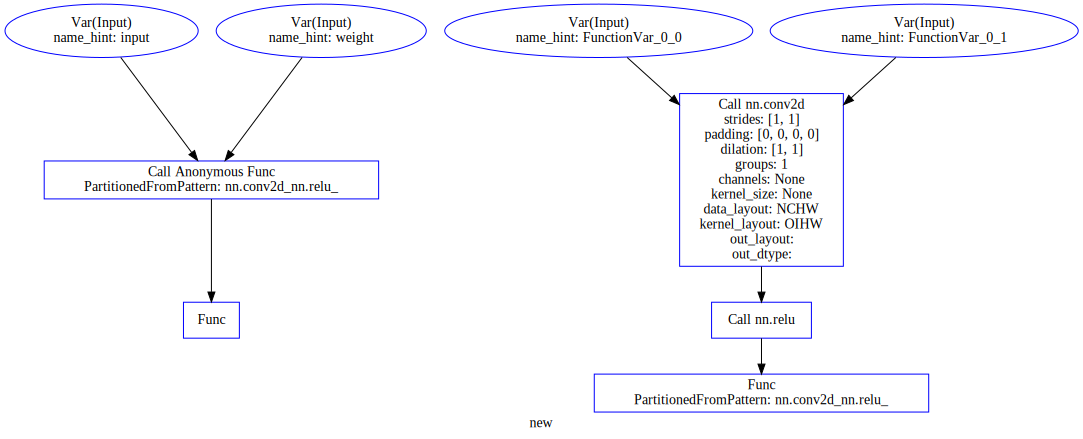

In [13]:
graphviz_relay(mod, "new")

In [14]:
print(pattern.partition(relu, {'Composite': 'one_layer'}))

free_var %input;
free_var %weight;
%1 = fn (%FunctionVar_0_0, %FunctionVar_0_1, PartitionedFromPattern="nn.conv2d_nn.relu_", Composite="one_layer") {
  %0 = nn.conv2d(%FunctionVar_0_0, %FunctionVar_0_1, padding=[0, 0, 0, 0]);
  nn.relu(%0)
};
%1(%input, %weight)


In [ ]:
partitioned.get_global_vars()